## Домашнее задание : "Обучение с подкреплением"

# Задание 1

Обучите алгоритм Q-learning для сред FrozenLake-v1 и Blackjack-v1, в частности подберите оптимальную alpha. (2 балла)

# Задание 2

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (3 балла)

In [4]:
# %pip install gymnasium
# %pip install "gym[toy_text]"

In [50]:
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

import gymnasium as gym
import numpy as np 
from gym.envs.toy_text.frozen_lake import generate_random_map

#create a single game instance
env = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array", is_slippery=True)

#start new game
env.reset();

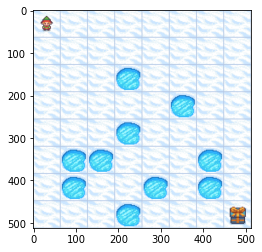

In [51]:
plt.imshow(env.render())

initial observation code: (0, {'prob': 1})
printing observation:
observations: Discrete(64) n= 64
actions: Discrete(4) n= 4


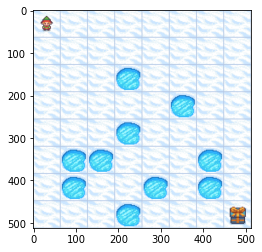

In [52]:
print("initial observation code:", env.reset())
print('printing observation:')
plt.imshow(env.render())
print("observations:", env.observation_space, 'n=', env.observation_space.n)
print("actions:", env.action_space, 'n=', env.action_space.n)

taking action 2 (right)
new observation code: 8
reward: 0.0
is game over?: False
printing new state:


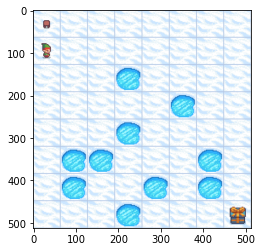

In [53]:
print("taking action 2 (right)")
new_obs, reward, is_done, _, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)
print("printing new state:")
plt.imshow(env.render())

In [54]:
action_to_i = {
    'left':0,
    'down':1,
    'right':2,
    'up':3
}

### Попробуйте походить по замерзшему озеру, не упав в дырку. 
* Каждый шаг вы с вероятностью __0.5__ будете двигаться в выбранном направлении и с вероятностью __0.5__ в случайном.
* Если упадете, используйте __env.reset()__ чтобы перезапустить __env__

In [55]:
env.reset()

(0, {'prob': 1})

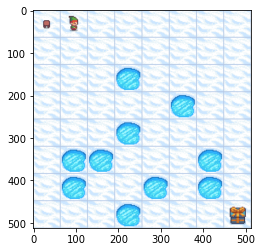

In [56]:
env.step(action_to_i['right'])
plt.imshow(env.render())

# Q Learning

In [57]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

import pickle5 as pickle
from tqdm.notebook import tqdm

## Create and Initialize the Q-table 🗄️

(👀 Step 1 of the pseudocode)

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-2.jpg" alt="Q-Learning" width="100%"/>


It's time to initialize our Q-table! To know how many rows (states) and columns (actions) to use, we need to know the action and observation space. We already know their values from before, but we'll want to obtain them programmatically so that our algorithm generalizes for different environments. Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`


In [61]:
# env = gym.make("Taxi-v3", render_mode="rgb_array")
env = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array", is_slippery=True)

In [62]:
# Create our Q table with state_size rows and action_size columns
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(env):
    state_space = env.observation_space.n
    print("There are ", state_space, " possible states")

    action_space = env.action_space.n
    print("There are ", action_space, " possible actions")
    
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [63]:
Qtable_frozen_lake = initialize_q_table(env)
print("Q-table shape: ", Qtable_frozen_lake .shape)
print(Qtable_frozen_lake)

There are  16  possible states
There are  4  possible actions
Q-table shape:  (16, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [64]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state][:])
  
  return action

In [65]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = random.uniform(0,1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = env.action_space.sample()

  return action

# Some configs for Jupyter

In [2]:
# %pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt

# !sudo apt-get update
# !sudo apt-get install -y python3-opengl
# !apt install ffmpeg xvfb
# !pip3 install pyvirtualdisplay

In [66]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# Set HyperParameters

In [91]:
# Training parameters
n_training_episodes = 30000  # Total training episodes
learning_rate = 0.69          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

env = gym.make(env_id, map_name="4x4", render_mode="rgb_array", is_slippery=True)
Qtable_frozen_lake = initialize_q_table(env)

There are  16  possible states
There are  4  possible actions


In [47]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        # Reset the environment
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

            # Our next state is the new state
            state = new_state
    return Qtable

# Train

In [95]:
Qtable_frozen_lake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozen_lake)
Qtable_frozen_lake

  0%|          | 0/30000 [00:00<?, ?it/s]

array([[1.22593935e-01, 6.27778696e-02, 1.10589277e-01, 8.94253392e-02],
       [6.32507430e-03, 1.58043546e-02, 1.95941377e-02, 1.08010091e-01],
       [2.92194223e-02, 3.00276960e-02, 3.86700042e-02, 4.10329174e-02],
       [1.12624061e-02, 1.28574187e-02, 1.21127894e-02, 3.57453087e-02],
       [1.29303334e-01, 1.70837688e-02, 1.32493164e-02, 2.99481511e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.43351572e-03, 1.41931754e-03, 3.45580410e-05, 1.26880572e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.73727258e-02, 1.24479018e-01, 8.40348251e-02, 1.91519302e-01],
       [8.08486577e-02, 1.66193214e-01, 5.71450414e-02, 1.45949180e-01],
       [5.69070211e-02, 2.26118764e-02, 3.33010122e-02, 3.80611819e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.17617195e-02, 1.87845892e-01, 5.17734755e

In [72]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [93]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_frozen_lake
}

In [103]:
evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

  0%|          | 0/100 [00:00<?, ?it/s]

(0.74, 0.4386342439892262)

In [109]:
env.reset()

(0, {'prob': 1})

In [110]:
def record_video(env, Qtable, out_directory, fps=1):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []  
    terminated = False
    truncated = False
    state, info = env.reset(seed=random.randint(0,500))
    img = env.render()
    images.append(img)
    while not terminated or truncated:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state][:])
        state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)])

In [113]:
record_video(env, model["qtable"], "a.mp4", 1)

In [114]:
from IPython.display import Video

Video("a.mp4", embed=True)

# Blackjack-v1

In [138]:
env = gym.make("Blackjack-v1" , render_mode="rgb_array")
observation, info = env.reset()
env.observation_space[1].n

2

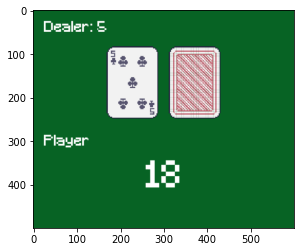

In [123]:
plt.imshow(env.render())

In [164]:
from collections import defaultdict

def initialize_q_table_bj(env):
    # Для среды Blackjack-v1 пространство состояний - (перебор игрока, карта дилера, наличие туза)
    state_space = (32, 11, 2)
    print("State space:", state_space)

    # Для среды Blackjack-v1 пространство действий - (0: 'Stand', 1: 'Hit')
    action_space = env.action_space.n
    print("Action space:", action_space)

    Qtable = defaultdict(lambda: np.zeros(env.action_space.n))

    return Qtable

In [179]:
# Training parameters
n_training_episodes = 100000  # Total training episodes
learning_rate = 0.02          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "Blackjack-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

env = gym.make(env_id, render_mode="rgb_array")
Qtable_blackjack = initialize_q_table_bj(env)

State space: (32, 11, 2)
Action space: 2


In [166]:
def get_action(Qtable, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return int(np.argmax(Qtable[state]))

In [180]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    train_error = []
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        # Reset the environment
        state, info = env.reset()
        terminated = False
        truncated = False

        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = get_action(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, _ = env.step(action)

            # Обновление Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            future_q_value = (not terminated) * np.max(Qtable[new_state])
            temporal_difference = (
                reward + gamma * future_q_value - Qtable[state][action]
            )

            Qtable[state][action] = (
                Qtable[state][action] + learning_rate * temporal_difference
            )
            train_error.append(temporal_difference)

            if terminated or truncated:
                break

            state = new_state

    return Qtable, train_error

In [181]:
Qtable_blackjack, train_error = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_blackjack)

  0%|          | 0/100000 [00:00<?, ?it/s]

# Visualizating the policy

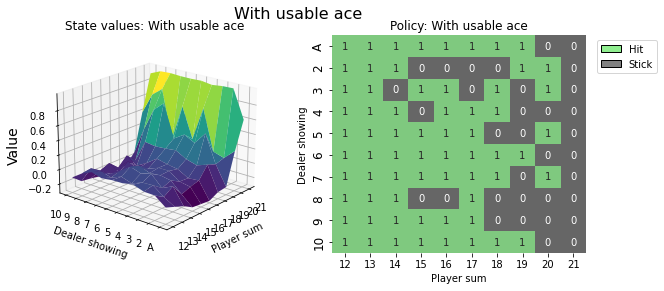

In [182]:
from matplotlib.patches import Patch
import seaborn as sns

def create_grids(qtable, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in qtable.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(Qtable_blackjack, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# Используемые learning rate
- Для FrozenLake 0.69 мне показал большую награду, чем другие, которые тестил
- Для BlackJacj 0.02 мне показал более гладкие результаты